# **ENSEMBLE MODEL**

The first step is importing our training data, modifying it to reflect the change that we determined was necessary from our EDA/descriptive analysis notebook, and then separating the predictors (X) from the target variables (y - depression and anxiety scores).

In [1]:
# importing libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from google.colab import files

uploaded = files.upload()
training_data = pd.read_csv('train.csv')

Saving train.csv to train (1).csv


In [2]:
# applying basic transformation to data that we established in EDA notebook, need to drop medication use and substance use columns

training_data = training_data.drop(['Medication_Use', 'Substance_Use'], axis=1)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            960 non-null    int64  
 1   Gender                         960 non-null    object 
 2   Education_Level                960 non-null    object 
 3   Employment_Status              960 non-null    object 
 4   Sleep_Hours                    960 non-null    float64
 5   Physical_Activity_Hrs          960 non-null    float64
 6   Social_Support_Score           960 non-null    int64  
 7   Anxiety_Score                  960 non-null    int64  
 8   Depression_Score               960 non-null    int64  
 9   Stress_Level                   960 non-null    int64  
 10  Family_History_Mental_Illness  960 non-null    int64  
 11  Chronic_Illnesses              960 non-null    int64  
 12  Therapy                        960 non-null    int

**Since we are trying to predict two target variables (depression and anxiety) we need to train and optimize the model twice - once with depression score as the target variable, and again with anxiety score as the target variable**

***Using depression score as the target first:***

In [7]:
# separating predictors from targets, using just depression score as our target

X_train = training_data.drop(columns=['Depression_Score', 'Anxiety_Score'])
y_train = training_data['Depression_Score']

In [8]:
X_train.head()

,Age,Gender,Education_Level,Employment_Status,Sleep_Hours,Physical_Activity_Hrs,Social_Support_Score,Stress_Level,Family_History_Mental_Illness,Chronic_Illnesses,Therapy,Meditation,Financial_Stress,Work_Stress,Self_Esteem_Score,Life_Satisfaction_Score,Loneliness_Score
0,56,Male,Bachelor's,Unemployed,6.0,0.4,3,9,0,0,0,1,4,3,7,5,1
1,69,Female,Bachelor's,Retired,8.8,2.8,6,6,0,0,1,0,1,4,7,4,6
2,46,Female,Master's,Employed,5.3,1.6,5,8,0,0,0,1,8,7,8,1,1
3,32,Female,High School,Unemployed,8.8,0.5,4,4,1,1,0,0,7,4,8,4,4
4,60,Female,Bachelor's,Retired,7.2,0.7,2,3,0,0,1,1,8,9,5,7,7


In [9]:
y_train.head()

,Depression_Score
0,2
1,7
2,13
3,3
4,15


The next step in the process of training and optimizing our ensemble model is doing all the necessary preprocessing steps to make sure the data is in a state in which it can be used to train an ensemble model. From lab 9 I know that these preprocessing steps can include things like encoding categorical variables and imputing missing values. From our previous steps and analysis we know that there are no more missing values, however there are categorical variables that have to be encoded. Since we want to embed preprocessing inside the cross-validatoin, we will accomplish this step in tandem with the optimizing and training of the model. We will use a random forest as our ensemble model, and use the KFold, GridSearchCV, and RandomForestRegressor classes to help us do this. We use RandomForestRegressor and not RandomForestClassifier because our target variables (depression and anxiety scores) are not labels, we aren't trying to correctly classify data points, but rather accurately predict continuous targets. To simultaneously accomplish the encoding of categorical variables and the cross validation needed to optimize the model, we will create a pipeline and use that within the GridSearchCV object.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

# splitting up numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns

# defining preprocessing tool, what should be done with numeric and categorical columns
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# creating pipeline to include preprocessing in creation of random forest model
pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

# hyperparameter grid, testing different hyperparameter combinations
rf_param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 5, 7, None],
    "model__max_features": ["sqrt", "log2", 0.5]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# grid search with regression scoring, using pipeline with preprocessing steps included in the cross validation/model optimizing
grid = GridSearchCV(
    pipeline,
    rf_param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# fit on actual training data
grid.fit(X_train, y_train)

# print results
print("Best Parameters:", grid.best_params_)
print("Best Score (MSE):", grid.best_score_)

Best Parameters: {'model__max_depth': 3, 'model__max_features': 'log2', 'model__n_estimators': 200}
Best Score (MSE): -32.98511388104914


Refitting and evaluating the model by training it again using those best parameters

In [12]:
# refit the best model on the full training data

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['Age', 'Sleep_Hours', 'Physical_Activity_Hrs', 'Social_Support_Score',
       'Stress_Level', 'Family_History_Mental_Illness', 'Chronic_Illnesses',
       'Therapy', 'Meditation', 'Financial_Stress', 'Work_Stress',
       'Self_Esteem_Score', 'Life_Satisfaction_Score', 'Loneliness_Score'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Education_Level', 'Employment_Status'], dtype='object'))])),
                ('model',
                 RandomForestRegressor(max_depth=3, max_features='log2',
                                       n_estimators=200, random_state=42))])

In [16]:
from sklearn.model_selection import cross_val_score

# RMSE (sq root of mean squared error)
rmse_scores = np.sqrt(-cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
))

# MAE (mean absolute error)
mae_scores = -cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_absolute_error"
)

# R^2 (pearson correlation coefficient)
r2_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="r2"
)

print("RMSE:", rmse_scores.mean())
print("MAE:", mae_scores.mean())
print("R²:", r2_scores.mean())

RMSE: 5.7126627850082405
MAE: 4.942441301557442
R²: -0.010398814694383729


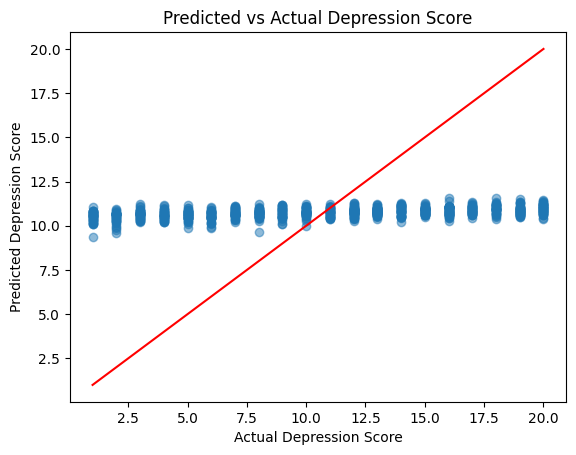

In [17]:
y_pred = best_model.predict(X_train)

plt.scatter(y_train, y_pred, alpha=0.5)
plt.xlabel("Actual Depression Score")
plt.ylabel("Predicted Depression Score")
plt.title("Predicted vs Actual Depression Score")
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         color='red')  # 45-degree line
plt.show()

# blue points represent model's predictions (plotted on X axis as what the actual score was, Y axis as what the predicted score was)
# red line represents the ideal actual scores v predicted scores trend, as actual scores increase the model is able to correctly predict those

***Using anxiety score as the target now***

In [18]:
y_train = training_data['Anxiety_Score']

Same process as before, just now fitting grid search object to new data with different target variable

In [19]:
# running same grid search as before
grid = GridSearchCV(
    pipeline,
    rf_param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# fitting on new data with anxiety score replacing depression score
grid.fit(X_train, y_train)

# print results
print("Best Parameters:", grid.best_params_)
print("Best Score (MSE):", grid.best_score_)

Best Parameters: {'model__max_depth': 3, 'model__max_features': 'log2', 'model__n_estimators': 200}
Best Score (MSE): -35.51224814546589


In [20]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

# RMSE (sq root of mean squared error)
rmse_scores = np.sqrt(-cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
))

# MAE (mean absolute error)
mae_scores = -cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_absolute_error"
)

# R^2 (pearson correlation coefficient)
r2_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="r2"
)

print("RMSE:", rmse_scores.mean())
print("MAE:", mae_scores.mean())
print("R²:", r2_scores.mean())

RMSE: 5.978406508568126
MAE: 5.184794760126905
R²: -0.022860704010819567


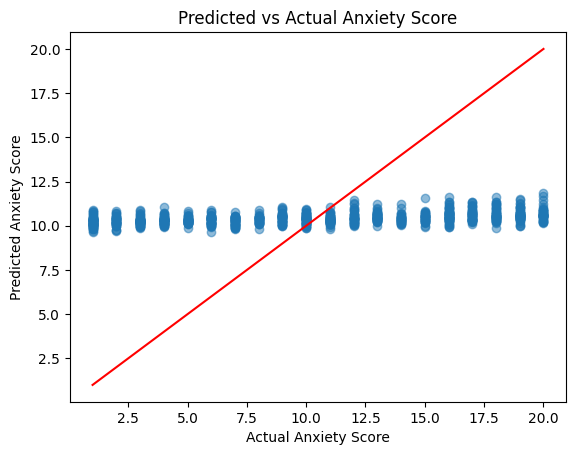

In [22]:
y_pred = best_model.predict(X_train)

plt.scatter(y_train, y_pred, alpha=0.5)
plt.xlabel("Actual Anxiety Score")
plt.ylabel("Predicted Anxiety Score")
plt.title("Predicted vs Actual Anxiety Score")
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         color='red')  # 45-degree line
plt.show()